*WARNING This is not production-ready code. There are no signs of some kind of good pipeline (with classes like data generators for preprocessing purposes, utility functions, well documented API, you name it). No signs of code commenting and proper documentation could be found either. Let's call this notebook a demonstration*

# Import Section

In [117]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import datashader as ds
import dask.dataframe as dd
from colorcet import fire, kgy
from datashader import transfer_functions as tf
from mpl_toolkits.mplot3d import axes3d
from scipy import stats
from sklearn.externals import joblib
%matplotlib inline

# Read data (& basic EDA)

In [6]:
df = pd.read_csv('Learn_sample.txt', delimiter = '\t', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,rs200345880,10,82691,NaN,AA,GA,AA,AA,AA,AG,...,GG,GG,GG,GG,AA,GG,GA,GG,GG,GA
1,rs10751931,10,95949,NaN,TC,TC,TC,TC,TT,TT,...,TT,TT,TT,TT,CT,TT,TT,TT,TT,TT
2,rs4266997,10,96434,NaN,CT,CT,CT,CT,CC,CC,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
3,rs4881370,10,109082,NaN,CT,CC,CT,CT,CC,CC,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
4,rs4242802,10,133998,NaN,GC,GG,GC,GC,GG,GG,...,GG,GG,GG,GG,CG,GG,GC,GG,GG,GC


In [7]:
tdf = pd.read_csv('Test_sample.txt', delimiter = '\t', header = None)
tdf.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,rs200345880,10,82691,NaN,AA,AA,GA,AA,GA,AA,...,GA,GG,GG,GG,GG,GA,GG,GG,GG,GG
1,rs10751931,10,95949,NaN,TT,TC,TT,TT,TC,CC,...,TT,TT,TT,TT,TT,TC,TT,TT,TT,TT
2,rs4266997,10,96434,NaN,CC,CT,CC,CC,CT,TT,...,CT,CC,CC,CC,CC,CT,CC,CC,CC,CC
3,rs4881370,10,109082,NaN,CC,CT,CC,CC,CT,TT,...,CT,CC,CC,CC,CC,CT,CC,CC,CC,CC
4,rs4242802,10,133998,NaN,GG,GC,GG,GG,GC,CC,...,GC,GG,GG,GG,GG,GC,GG,GG,GG,GG


In [8]:
del df[3]
del tdf[3]

In [9]:
df.head()

,0,1,2,4,5,6,7,8,9,10,...,94,95,96,97,98,99,100,101,102,103
0,rs200345880,10,82691,AA,GA,AA,AA,AA,AG,AA,...,GG,GG,GG,GG,AA,GG,GA,GG,GG,GA
1,rs10751931,10,95949,TC,TC,TC,TC,TT,TT,TC,...,TT,TT,TT,TT,CT,TT,TT,TT,TT,TT
2,rs4266997,10,96434,CT,CT,CT,CT,CC,CC,CT,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
3,rs4881370,10,109082,CT,CC,CT,CT,CC,CC,CT,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
4,rs4242802,10,133998,GC,GG,GC,GC,GG,GG,GC,...,GG,GG,GG,GG,CG,GG,GC,GG,GG,GC


In [12]:
len(df)

250000

First columns do not seem useful (at least, two of them). I figured out later that the first column could be split, but it remained useless anyway

In [13]:
len(df[0].unique())

249998

In [14]:
len(df[1].unique())

17

In [15]:
len(df[2].unique())

249842

In [16]:
len(tdf)

250000

We need to perform some encoding on markers, so let's concatenate datasets in order to eliminate unseen markers situations later

In [17]:
fulldf = pd.concat([df, tdf], ignore_index = True)
fulldf.head()

,0,1,2,4,5,6,7,8,9,10,...,94,95,96,97,98,99,100,101,102,103
0,rs200345880,10,82691,AA,GA,AA,AA,AA,AG,AA,...,GG,GG,GG,GG,AA,GG,GA,GG,GG,GA
1,rs10751931,10,95949,TC,TC,TC,TC,TT,TT,TC,...,TT,TT,TT,TT,CT,TT,TT,TT,TT,TT
2,rs4266997,10,96434,CT,CT,CT,CT,CC,CC,CT,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
3,rs4881370,10,109082,CT,CC,CT,CT,CC,CC,CT,...,CC,CC,CC,CC,TC,CC,CT,CC,CC,CT
4,rs4242802,10,133998,GC,GG,GC,GC,GG,GG,GC,...,GG,GG,GG,GG,CG,GG,GC,GG,GG,GC


let's see how many markers there are in the dataset

In [18]:
len(fulldf[6].unique())

343

In [19]:
len(np.unique(fulldf.iloc[:, 3:].values.flatten()))

1196

# Transform Data

encoding procedure - gathering all possible markers, flattening, categorization, encoding, reshaping again

In [20]:
markers_df = pd.DataFrame(fulldf.iloc[:, 3:].values.flatten(), columns = ['marker'])
markers_df['marker'] = markers_df['marker'].astype('category')
markers_cat = markers_df['marker'].cat.codes.values.reshape(-1, 100)
markers_cat.shape

(500000, 100)

replacing markers with encoded data

In [21]:
fulldf_cats = fulldf.iloc[:, 0:3].copy()
for i in np.arange(0, markers_cat.shape[1], 1) + 3:
    fulldf_cats[i] = markers_cat[:, i - 3]
fulldf_cats.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,rs200345880,10,82691,0,658,0,0,0,145,0,...,759,759,759,759,0,759,658,759,759,658
1,rs10751931,10,95949,975,975,975,975,1089,1089,975,...,1089,1089,1089,1089,569,1089,1089,1089,1089,1089
2,rs4266997,10,96434,569,569,569,569,427,427,569,...,427,427,427,427,975,427,569,427,427,569
3,rs4881370,10,109082,569,427,569,569,427,427,569,...,427,427,427,427,975,427,569,427,427,569
4,rs4242802,10,133998,726,759,726,726,759,759,726,...,759,759,759,759,523,759,726,759,759,726


saving codes for later use

In [22]:
codes = np.unique(markers_df['marker'].cat.codes.values)

In [23]:
markers_df['marker_code'] = markers_df['marker'].cat.codes.values
mdict = markers_df[['marker', 'marker_code']].copy().drop_duplicates()
len(mdict)

1196

In [26]:
mdict = markers_df[['marker', 'marker_code']].copy().drop_duplicates()

In [27]:
mdict.reset_index(inplace = True)
del mdict['index']
mdict.to_feather('mdict.feather')

In [28]:
mdict[mdict['marker_code'] == 1195]

,marker,marker_code
84,TTTTTTG,1195


Split data into train and test samples again

In [29]:
df_cats = fulldf_cats.iloc[0:250000, :].copy()
tdf_cats = fulldf_cats.iloc[250000:, :].copy()

checking the first column unique data after splitting values in it

In [31]:
marker_labels_set = set([x for l in fulldf_cats[0].apply(lambda x: x.split(';')) for x in l])
len(marker_labels_set)

250693

Transpose matrices (since columns are people)

In [32]:
df_cats = df_cats.T.copy()
tdf_cats = tdf_cats.T.copy()

In [34]:
df_cats.head()

,0,1,2,3,4,5,6,7,8,9,...,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
0,rs200345880,rs10751931,rs4266997,rs4881370,rs4242802,rs9419554,rs4881552,rs10903349,rs11594819,rs4469806,...,rs4355430,rs6830755,rs6817563,rs11723800,rs7654368,rs4862481,rs7694916,rs7675638,rs34276979,rs11132271
1,10,10,10,10,10,10,10,10,10,10,...,4,4,4,4,4,4,4,4,4,4
2,82691,95949,96434,109082,133998,135237,159299,160478,162102,171117,...,185885897,185889178,185890485,185896240,185896851,185910197,185917159,185917578,185925147,185927594
3,0,975,569,569,726,658,899,658,0,145,...,569,899,569,1089,1089,0,427,759,759,975
4,658,975,569,427,759,759,1089,759,0,0,...,427,1089,427,209,569,0,975,759,759,427


In [36]:
len(df_cats)

103

# PCA

In [64]:
pca = PCA(n_components=99)

In [65]:
components = pca.fit_transform(df_cats.iloc[3:, :].values)
components.shape

(100, 99)

In [66]:
pca.explained_variance_ratio_

array([0.12732241, 0.01069726, 0.01060533, 0.01023335, 0.01010467,
       0.00994874, 0.00993605, 0.00990712, 0.00979929, 0.00977562,
       0.00975822, 0.0097249 , 0.00966922, 0.00965333, 0.00963804,
       0.0095944 , 0.00954213, 0.00949253, 0.00948093, 0.00947214,
       0.00945701, 0.0094361 , 0.00939883, 0.00938791, 0.00937087,
       0.00936315, 0.00932384, 0.00931112, 0.00929999, 0.00925231,
       0.0092224 , 0.00921732, 0.00921351, 0.00917996, 0.0091571 ,
       0.00913732, 0.00910092, 0.00909356, 0.00906584, 0.00903752,
       0.00903016, 0.0090216 , 0.00899177, 0.00898444, 0.00896948,
       0.0089371 , 0.00893577, 0.00890982, 0.00887874, 0.00886232,
       0.0088562 , 0.00882916, 0.00881137, 0.0087991 , 0.00878931,
       0.00878354, 0.00873376, 0.00872332, 0.00868687, 0.0086816 ,
       0.00867142, 0.00865058, 0.00863995, 0.00861588, 0.00860814,
       0.00857514, 0.00853858, 0.00851628, 0.00850768, 0.00849503,
       0.00848194, 0.00847009, 0.008448  , 0.00842984, 0.00840

99 components sum up to 100% explained variance. 

In [68]:
np.sum(pca.explained_variance_ratio_)

1.0

In [118]:
joblib.dump(pca, 'pca.pkl')
pca = joblib.load('pca.pkl')

## Visualize train

In some projections two clusters appear clearly.

In [70]:
sns.set()
sns.set_style('white', {'axes.grid': False, 'axes.edgecolor': '0.9'})

In [71]:
columns = ['pca{}'.format(x) for x in np.arange(1, 100, 1)]

In [72]:
components = pd.DataFrame(components, columns = columns)
components.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98,pca99
0,49321.282867,8798.088240,-4830.268167,8469.249994,1556.172377,-1943.408519,-802.614651,-19894.386822,-14224.062514,-8417.485573,...,-200.829316,18248.737579,2057.669206,-13115.077622,807.014997,2198.397909,11784.929119,-10576.576699,6467.874498,13357.096531
1,48730.331693,4592.487978,-10885.654708,18052.337288,2909.429086,-8375.370353,2921.745352,3800.713842,12396.886790,-5210.860080,...,-5990.309336,-13750.243464,15039.648215,11676.471273,-1324.455188,5991.536437,-17511.031835,5215.465056,4273.726710,1986.939582
2,49093.455329,-5202.755695,-21856.806782,-7377.903381,-9611.502656,-10347.669582,13831.175279,-5189.998839,44.487259,3674.550494,...,9272.469593,-35.145491,10927.998257,-18930.742481,6829.534796,442.049953,-5604.507763,4658.411522,-10099.933991,10750.596267
3,49591.540244,-1938.368477,-839.723635,-7004.826308,13785.618899,-7176.079569,-9567.884844,12781.510173,10010.835967,8703.921508,...,4425.587850,13099.646930,-15738.176352,-3665.649034,2532.763004,6990.405956,-1819.189935,-4782.504285,10147.533865,-2987.717953
4,47143.161883,3135.358459,-24926.651225,8139.092037,-9309.444301,9090.632846,19023.083124,5567.639312,13814.732265,-28844.997818,...,14023.513016,-9261.886292,-9052.574619,7769.892144,9715.972008,12997.895835,6634.934588,-418.102710,7400.144508,2994.062915


### componet1 - component2 projection

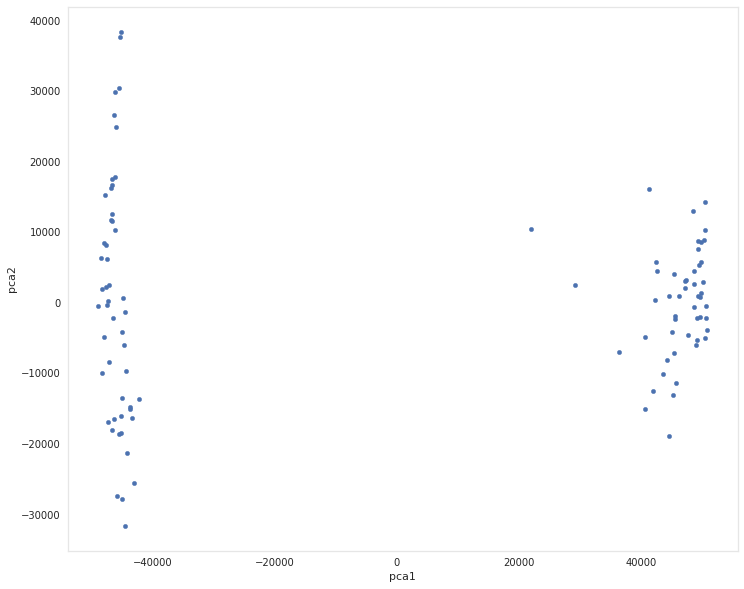

In [77]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca1', y = 'pca2', ax = ax) #, palette = sns.color_palette("YlGnBu", n_colors=2)

### component2 - component3 projection

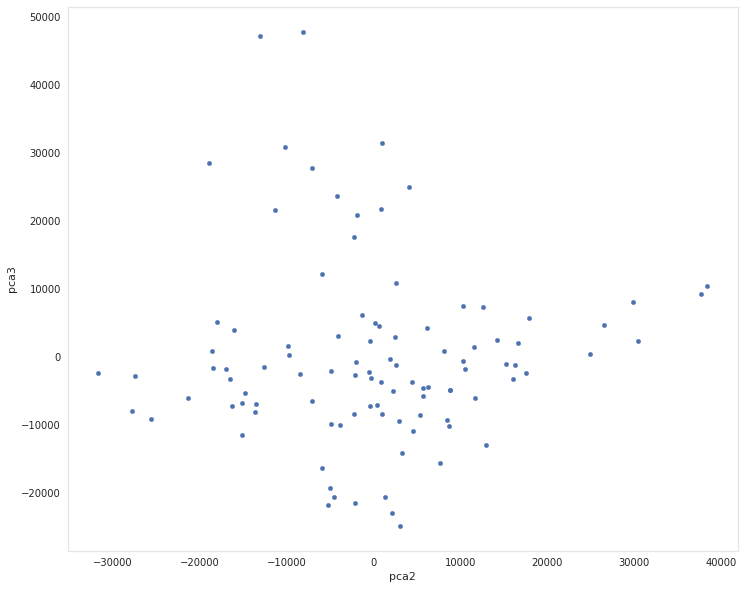

In [78]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca2', y = 'pca3', ax = ax)

### component3 - component4 projection

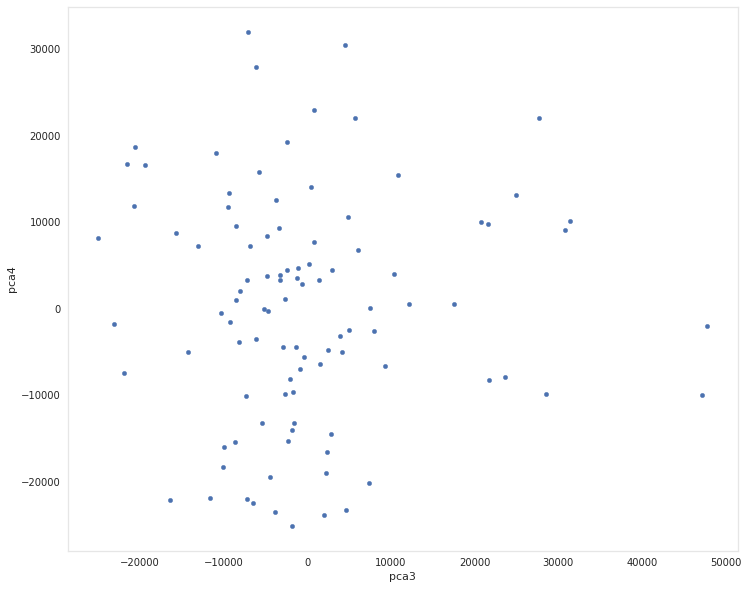

In [79]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca3', y = 'pca4', ax = ax)

## Visualize test

To be sure that test data distribution is similar to the one of the train dataset

In [80]:
components_test = pca.transform(tdf_cats.iloc[3:, :].values)
components_test = pd.DataFrame(components_test, columns = columns)
components_test.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca90,pca91,pca92,pca93,pca94,pca95,pca96,pca97,pca98,pca99
0,45761.229403,-529.115877,-497.471158,1014.734928,959.655137,-140.485077,-442.265481,-502.729468,431.224734,109.950812,...,-19.426020,-468.003159,-51.148715,-569.101076,-90.113639,981.179803,-472.679806,-411.020436,-622.332154,325.501874
1,32489.058713,1286.830388,-99.171877,2999.108846,758.652334,427.511050,193.266274,493.418627,-1198.797139,-398.690281,...,-356.041064,-892.009871,1191.056554,299.474111,949.710787,690.892540,130.929819,-80.614291,638.546223,-678.305635
2,41332.779526,-846.517392,5492.296447,1591.015703,394.859026,-1274.493515,-521.759969,-167.271760,532.209407,507.740786,...,877.593632,1087.523394,-682.585059,-372.720427,760.389553,742.511630,-1076.739619,523.306734,119.968743,-1181.539882
3,25022.570990,-1554.415176,-1214.680965,-781.343734,468.552306,-2386.726883,588.974399,565.299723,51.790538,395.409390,...,334.576855,1040.262115,-888.462910,54.616022,253.389759,-821.280389,-471.904930,-110.410660,-185.113172,-610.826731
4,44613.111108,-620.507732,-2428.757240,876.800094,55.545563,-676.996511,-64.080428,-414.716662,-338.942103,-2152.857936,...,437.623832,286.613184,1164.452590,717.913843,36.866229,518.776784,337.028974,-535.521618,-333.701557,128.508673


### component1 - component2 projection

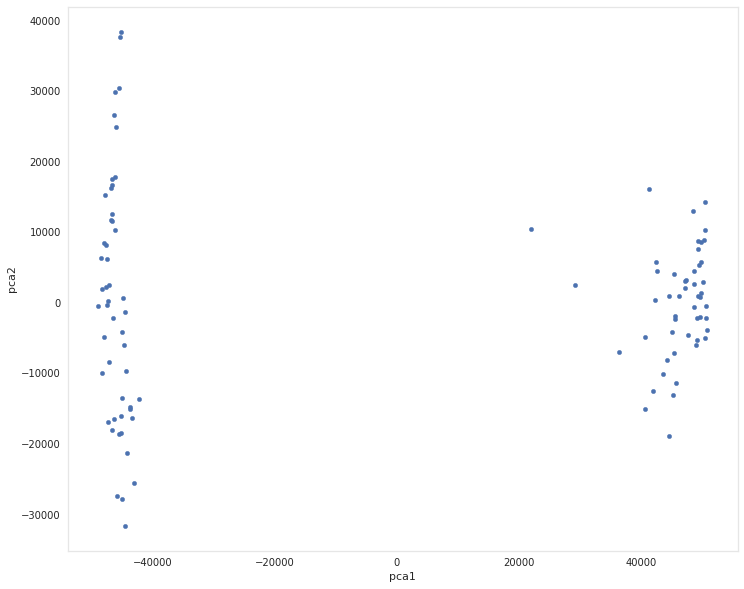

In [81]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca1', y = 'pca2', ax = ax)

### component2 - component3 projection

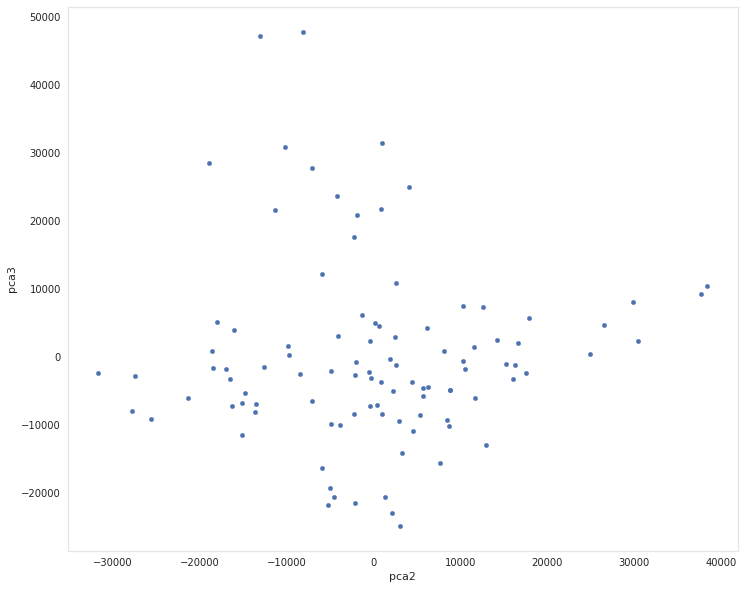

In [82]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca2', y = 'pca3', ax = ax)

### component3 - component4 projection

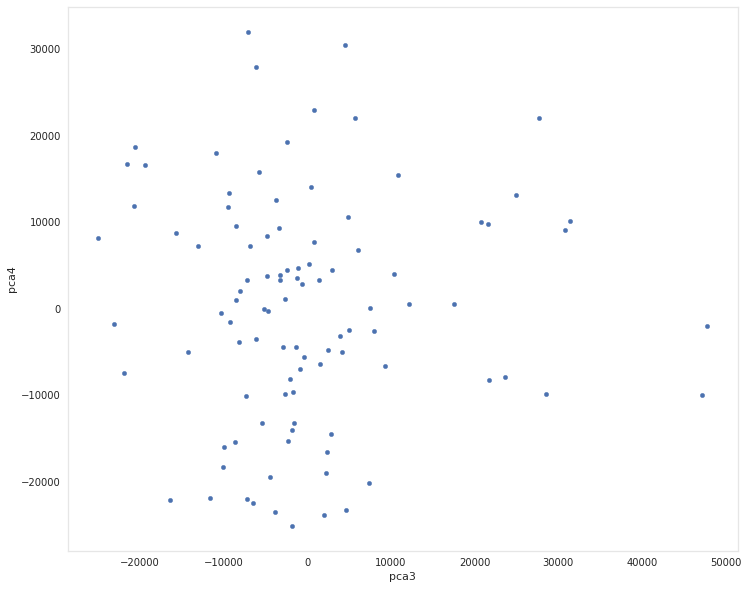

In [83]:
f, ax = plt.subplots(figsize=(12, 10))
components.plot.scatter(x = 'pca3', y = 'pca4', ax = ax)

## 3D vis

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


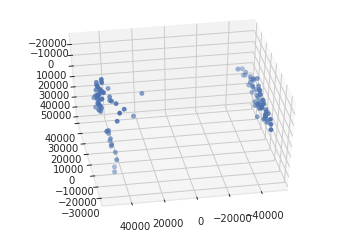

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = fig.gca(projection='3d')
ax.scatter(components['pca1'].values, components['pca2'].values, components['pca3'].values)
ax.azim = 100
ax.elev = -135
plt.show()

# Clustering

We could use just 3 first components, since 3d projection shows two clusters, but using a hundred is possible on my machine too.

In [85]:
cl = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, random_state=0, n_jobs=8).fit(components)

In [86]:
labels = cl.labels_
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [87]:
sum(labels)

50

In [88]:
components['label'] = labels

# Clusters visualization

### componet1 - component2 projection

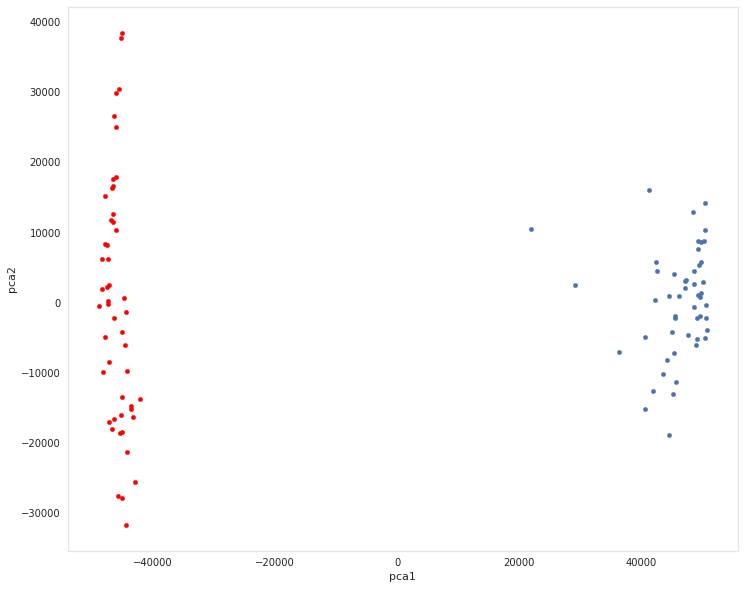

In [90]:
f, ax = plt.subplots(figsize=(12, 10))
components[components['label'] == 1].plot.scatter(x = 'pca1', y = 'pca2', ax = ax)
components[components['label'] == 0].plot.scatter(x = 'pca1', y = 'pca2', ax = ax, c = 'r')

### componet2 - component3 projection

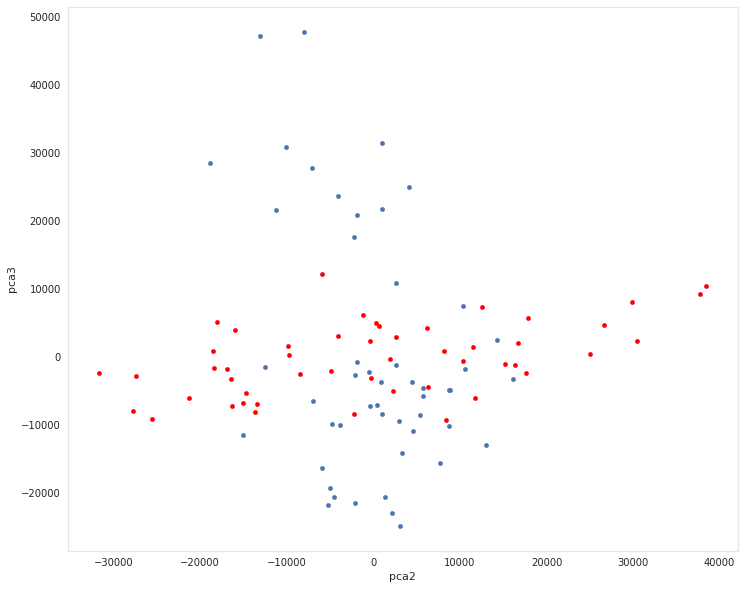

In [91]:
f, ax = plt.subplots(figsize=(12, 10))
components[components['label'] == 1].plot.scatter(x = 'pca2', y = 'pca3', ax = ax)
components[components['label'] == 0].plot.scatter(x = 'pca2', y = 'pca3', ax = ax, c = 'r')

### componet3 - component4 projection

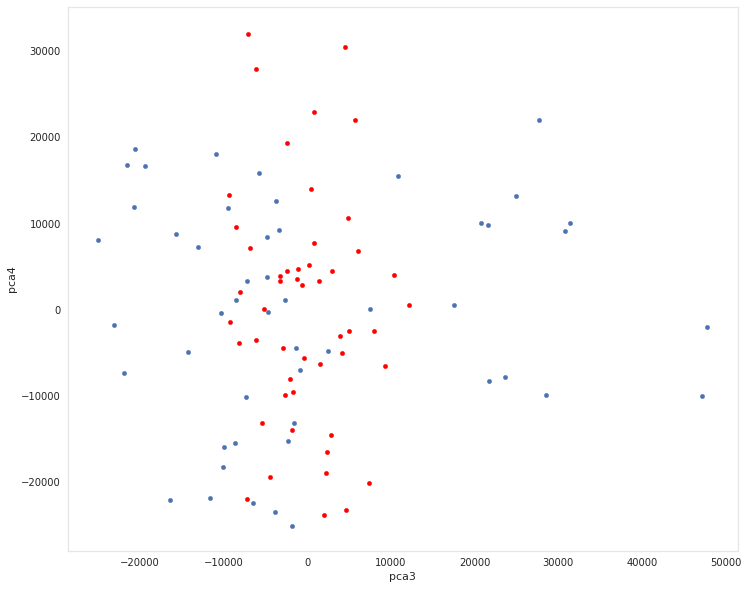

In [92]:
f, ax = plt.subplots(figsize=(12, 10))
components[components['label'] == 1].plot.scatter(x = 'pca3', y = 'pca4', ax = ax)
components[components['label'] == 0].plot.scatter(x = 'pca3', y = 'pca4', ax = ax, c = 'r')

# Save preprocessed and labelled data for further use

In [94]:
df_cats = df_cats.iloc[3:, :].copy()

In [95]:
df_cats['label'] = labels
df_cats.head()

,0,1,2,3,4,5,6,7,8,9,...,249991,249992,249993,249994,249995,249996,249997,249998,249999,label
3,0,975,569,569,726,658,899,658,0,145,...,899,569,1089,1089,0,427,759,759,975,1
4,658,975,569,427,759,759,1089,759,0,0,...,1089,427,209,569,0,975,759,759,427,1
5,0,975,569,569,726,658,899,658,317,0,...,0,975,899,975,0,427,759,759,427,1
6,0,975,569,569,726,658,899,658,0,145,...,1089,427,209,427,899,427,759,658,569,1
7,0,1089,427,427,759,759,1089,759,0,145,...,899,569,899,975,0,427,759,759,427,1


In [96]:
df_cats.rename(columns = dict(zip(list(df_cats.columns), np.array(list(df_cats.columns)).astype(str))), inplace = True)

In [98]:
df_cats.reset_index(inplace = True)
del df_cats['index']
df_cats.to_feather('labeld_train.feather')

In [99]:
tdf_cats.rename(columns = dict(zip(list(tdf_cats.columns), np.array(list(tdf_cats.columns)).astype(str))), inplace = True)

In [100]:
tdf_cats.columns

Index(['250000', '250001', '250002', '250003', '250004', '250005', '250006',
       '250007', '250008', '250009',
       ...
       '499990', '499991', '499992', '499993', '499994', '499995', '499996',
       '499997', '499998', '499999'],
      dtype='object', length=250000)

In [104]:
tdf_cats = tdf_cats.iloc[3:, :].copy()

In [105]:
tdf_cats.reset_index(inplace = True)
tdf_cats.head()

,index,250000,250001,250002,250003,250004,250005,250006,250007,250008,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
0,3,0,1089,427,427,759,759,1089,759,0,...,1089,0,1089,899,427,209,427,759,759,427
1,4,0,975,569,569,726,658,899,658,0,...,975,209,975,1089,569,0,975,759,759,1089
2,5,658,1089,427,427,759,759,899,759,0,...,427,1089,427,1089,1089,0,975,145,145,975
3,6,0,1089,427,427,759,759,1089,759,0,...,427,1089,427,1089,569,0,975,145,145,1089
4,7,658,975,569,569,726,658,899,658,0,...,427,1089,427,1089,569,899,1089,145,658,1089


In [106]:
del tdf_cats['index']

In [107]:
tdf_cats.to_feather('preprocessed_test.feather')

# Training

This part of the notebook is completely independent. However, it's not like it could be used for making production scripts, since this code uses already preprocessed data.

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline

df = pd.read_feather('labeld_train.feather')
tdf = pd.read_feather('preprocessed_test.feather')

kf = StratifiedShuffleSplit(n_splits=1, test_size = 0.25)
X = df.copy()
y = df['label']
del X['label']
folds = list(kf.split(X, y))

xfold0_train, xfold0_test = X.iloc[folds[0][0], :], X.iloc[folds[0][1], :]
yfold0_train, yfold0_test = y[folds[0][0]], y[folds[0][1]]

In [150]:
def fitprint(param, xtrain, ytrain,  xtest, ytest):
    
    pca = joblib.load('pca.pkl')
    xtrain = pd.DataFrame(pca.transform(xtrain))
    xtest = pd.DataFrame(pca.transform(xtest))
    gbr = LogisticRegression(**param)
    gbr.fit(xtrain, ytrain.values.astype('float64'))
    
    pred = gbr.predict_proba(xtest)[:, 1]
    
    predtrain = gbr.predict_proba(xtrain)[:, 1]
    
    print('Accuracy of classifier on training set: {:.4f}'
         .format(gbr.score(xtrain, ytrain.values.astype('float64'))))
    print('Accuracy of classifier on test set: {:.4f}'
         .format(gbr.score(xtest, ytest.values.astype('float64'))))
    print('Logloss of classifier on train set: {:.4f}'
        .format(log_loss(ytrain.values.astype('float64'), predtrain)))
    print('Logloss of classifier on testset: {:.4f}'
        .format(log_loss(ytest.values.astype('float64'), pred)))
    
    pre = precision_score(ytest, np.round(pred, 0))
    print('Precision score of classifier on test set: {:.4f}'.format(pre))
    
    re = recall_score(ytest, np.round(pred, 0))
    print('Recall score of classifier on test set: {:.4f}'.format(re))
    
    f1 = f1_score(ytest, np.round(pred, 0))
    print('F1 score of classifier on test set: {:.4f}'.format(f1))
    
    confm = confusion_matrix(ytest.values, np.round(pred, 0))
    print(confm)
    
    return gbr

In [151]:
param = {'penalty':'l2', 'C':0.5, 'max_iter':100, 'n_jobs':8, 'random_state':0}

# param = {'random_state':0, 'learning_rate':0.05, 'n_estimators':300, 'min_samples_split':100, 'subsample': 0.8, 'max_features': 0.8, 'verbose': False}

gbr0 = fitprint(param, xfold0_train, yfold0_train,  xfold0_test, yfold0_test)
pca = joblib.load('pca.pkl')
# save model for future use
joblib.dump(gbr0, 'classifier.pkl')
gbr0 = joblib.load('classifier.pkl')

# prediction
tdf = pd.DataFrame(pca.transform(tdf))
tdf['label'] = gbr0.predict(tdf)

tdf.rename(columns = dict(zip(list(tdf.columns), np.array(list(tdf.columns)).astype(str))), inplace = True)

tdf.to_feather('predicted_test.feather')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(self.n_jobs))


Accuracy of classifier on training set: 1.0000
Accuracy of classifier on test set: 1.0000
Logloss of classifier on train set: 0.0000
Logloss of classifier on testset: 0.0003
Precision score of classifier on test set: 1.0000
Recall score of classifier on test set: 1.0000
F1 score of classifier on test set: 1.0000
[[13  0]
 [ 0 12]]


save labels for check

In [155]:
df.label.to_csv('learn_labels.csv')
tdf.label.to_csv('test_labels.csv')